In [827]:
# from google.colab import drive
# drive.mount('/content/drive')

# 0. Preamble

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statistics
from sklearn.linear_model import LinearRegression
import os
import sqlite3
import sys

In [3]:
# notebook_path = '/content/drive/MyDrive/Colab_Notebooks/ISER/code/'
# os.chdir(notebook_path)

In [4]:
from functions import concat_dataset

In [5]:
data = pd.read_csv("../raw_data/global_crisis_data_country.csv", encoding='unicode_escape')
data.drop(0, inplace = True)
data.shape

(15190, 27)

In [6]:
data.rename(columns={'Banking Crisis ':'banking_crisis',
                    'Systemic Crisis':'systemic_crisis',
                    'Banking_Crisis_Notes':'notes',
                    'Currency Crises':'currency_crisis',
                    'Inflation Crises':'inflation_crisis',
                    'Gold Standard':'gold_standard',
                    'SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors': 'sovereign_external_debt_1',
                    'SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors': 'sovereign_external_debt_2',
                    'Inflation, Annual percentages of average consumer prices':'annual_inflation'},
            inplace = True)

data['Year'] = data['Year'].astype(int)

columns_to_convert = ['banking_crisis', 'systemic_crisis', 'annual_inflation', 'currency_crisis', 'inflation_crisis']
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [8]:
GDP_pc = pd.read_csv('../raw_data/gdp-per-capita-maddison.csv')
GDP_pc.drop(columns='417485-annotations', inplace = True)
GDP_pc.rename(columns={'GDP per capita':'GDP_per_capita'}, inplace = True)

# 1. Selecting countries for global analysis

In [10]:
# List of countries
OCDE = ['DEU', 'AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'COL', 'KOR', 'DNK', 'ESP', 'EST', 'USA', 'FIN', 'FRA', 'GRC', 'HUN', 'IRL', 'ISL', 'ISR', 'ITA', 'JPN', 'MEX', 'NOR', 'NZL', 'NLD', 'POL', 'PRT', 'SVQ', 'GBR', 'SVN', 'CZE', 'SWE', 'CHE', 'TUR']
G7 = ['CAN', 'FRA', 'DEU', 'ITA', 'JPN', 'GBR', 'USA']
G20 = ['DEU', 'CAN', 'FRA', 'GBR', 'JPN', 'ITA', 'USA', 'ZAF', 'SAU', 'RUS', 'CHN', 'ARG', 'BRA', 'IND', 'KOR', 'MEX', 'TUR', 'IDN']
UE = ['DEU', 'AUT', 'BEL', 'DNK', 'ESP', 'NLD', 'POL', 'PRT', 'SWD']
USA = ['USA']

#Select a list among those listed above:
countries_selected = G7

#Create a dataset with the data of the countries of the list
global_data = concat_dataset(GDP_pc, data, countries_selected, 'left')

In [11]:
# Generate a boolean mask where True indicates non-NaN values
not_nan_mask = ~np.isnan(global_data['annual_inflation'])

# Creating a dummy for the years with a banking crisis and no inflation crisis
global_data['banking_crisis_only'] = ((global_data['banking_crisis'] == 1) &
                                      (global_data['inflation_crisis'] != 1) &
                                      (global_data['currency_crisis'] != 1) &
                                      not_nan_mask )
global_data['banking_crisis_only'] = global_data['banking_crisis_only'].astype(int)
banking_crisis_year = global_data[global_data['banking_crisis_only'] == 1]['Year'].tolist() #Appending those years to a list

#Create a dummy variable for excluded years
global_data['excluded_years'] = ((global_data['inflation_crisis'] == 1) &
                                (global_data['currency_crisis'] != 1))

# Creating a dummy for the first years of crisis with a banking crisis and no inflation crisis
global_data['banking_crisis_only_first_year'] = 0

# Initialize variable to keep track of the last row where Dummy took value 1
last_crisis_year = None
crisis_period = False
banking_crisis_only_previous = None

for index, row in global_data.iterrows():
    if row['banking_crisis'] == 1:
        crisis_already_begun = False
        if row['banking_crisis_only'] == 1 and banking_crisis_only_previous != 1:
            if not crisis_already_begun:
                if last_crisis_year is None:
                    global_data.at[index, 'banking_crisis_only_first_year'] = 1
                # If the current row's Dummy column is 1, check the year difference
                if ((last_crisis_year is not None and row['Year'] - last_crisis_year >= 2) or (last_crisis_year is not None and row['Year'] - last_crisis_year <0)):
                    global_data.at[index, 'banking_crisis_only_first_year'] = 1
                    crisis_already_begun = True
        last_crisis_year = row['Year']
        banking_crisis_only_previous = row['excluded_years']

    else:
        crisis_already_begun = False

#Create a dummy for banking crisis years but not being the first year of a crisis
global_data['banking_crisis_only_not_first'] = global_data['banking_crisis_only'] - global_data['banking_crisis_only_first_year']

#Create a dummy for recovery period
global_data['recovery_only'] = ((global_data['banking_crisis'] != 1) &
                                (global_data['inflation_crisis'] != 1) &
                                (global_data['systemic_crisis'] != 1) &
                                (global_data['currency_crisis'] != 1) &
                                not_nan_mask)
global_data['recovery_only'] = global_data['recovery_only'].astype(int)

banking_crisis_only_first_year = global_data[global_data['banking_crisis_only_first_year'] == 1]['Year'].tolist()  #Appending those years to a list

print(f'In this approch, we record {len(banking_crisis_only_first_year)} different crisis event.')
banking_crisis_only_first_year

In this approch, we record 65 different crisis event.


[1873,
 1906,
 1912,
 1923,
 1983,
 1802,
 1805,
 1827,
 1838,
 1848,
 1867,
 1881,
 1889,
 1907,
 1930,
 1994,
 2008,
 1857,
 1880,
 1901,
 1929,
 1977,
 2008,
 1866,
 1889,
 1891,
 1893,
 1907,
 1914,
 1921,
 1930,
 1935,
 1990,
 2008,
 1872,
 1882,
 1901,
 1907,
 1927,
 1992,
 1811,
 1814,
 1825,
 1837,
 1847,
 1857,
 1866,
 1878,
 1890,
 1908,
 1974,
 1984,
 1991,
 1995,
 2007,
 1817,
 1825,
 1837,
 1841,
 1857,
 1861,
 1884,
 1907,
 1984,
 2007]

In [12]:
global_data

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,banking_crisis_only_not_first,recovery_only
0,9.0,CAN,Canada,1800,0.0,NaN,0.0,0,0.2441,NaN,...,NaN,0,0,0.0,NaN,0,False,0,0,0
1,9.0,CAN,Canada,1801,0.0,NaN,0.0,0,0.2379,NaN,...,NaN,0,0,0.0,NaN,0,False,0,0,0
2,9.0,CAN,Canada,1802,0.0,NaN,0.0,0,0.2553,NaN,...,NaN,0,0,0.0,NaN,0,False,0,0,0
3,9.0,CAN,Canada,1803,0.0,NaN,0.0,0,0.2527,NaN,...,NaN,0,0,0.0,NaN,0,False,0,0,0
4,9.0,CAN,Canada,1804,0.0,NaN,0.0,0,0.243,NaN,...,NaN,0,0,0.0,NaN,0,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,66.0,USA,United States,2012,0.0,NaN,0.0,0,1.6251,NaN,...,2.1,1,0,0.0,-2.14,0,False,0,0,1
1515,66.0,USA,United States,2013,0.0,NaN,0.0,0,1.6556,NaN,...,1.5,1,0,0.0,-2.22,0,False,0,0,1
1516,66.0,USA,United States,2014,0.0,NaN,0.0,0,1.5573,NaN,...,1.6,1,0,0.0,-1.66,0,False,0,0,1
1517,66.0,USA,United States,2015,NaN,NaN,0.0,0,1.4738,NaN,...,0.1,1,0,NaN,-0.88,0,False,0,0,1


In [22]:
crisis_duration = []
current_length = 0

for index, row in global_data.iterrows():
    if current_length > 0:
        if row['banking_crisis'] == 1:
            current_length += 1
        else:
            crisis_duration.append(current_length)
            current_length = 0
    else:
        if row['banking_crisis_only_first_year'] == 1:
           current_length = +1

#Check if the last sequence extends to the end of the dataset
if current_length > 0:
    crisis_duration.append(current_length)

print(crisis_duration)
print(len(crisis_duration))
print(banking_crisis_only_first_year)
print(len(banking_crisis_only_first_year))

[1, 2, 1, 1, 3, 1, 2, 2, 2, 1, 2, 2, 1, 1, 3, 2, 7, 1, 1, 1, 4, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 1, 6, 7, 5, 4, 1, 1, 1, 10, 1, 4, 2, 3, 2, 2, 1, 2, 1, 1, 3, 1, 1, 1, 8, 3, 1, 2, 1, 1, 1, 1, 1, 8, 4]
65
[1873, 1906, 1912, 1923, 1983, 1802, 1805, 1827, 1838, 1848, 1867, 1881, 1889, 1907, 1930, 1994, 2008, 1857, 1880, 1901, 1929, 1977, 2008, 1866, 1889, 1891, 1893, 1907, 1914, 1921, 1930, 1935, 1990, 2008, 1872, 1882, 1901, 1907, 1927, 1992, 1811, 1814, 1825, 1837, 1847, 1857, 1866, 1878, 1890, 1908, 1974, 1984, 1991, 1995, 2007, 1817, 1825, 1837, 1841, 1857, 1861, 1884, 1907, 1984, 2007]
65


In [23]:
length_counts = {}
for length in crisis_duration:
    if length in length_counts:
        length_counts[length] += 1
    else:
        length_counts[length] = 1

# Convert dictionary to pandas DataFrame
len_freq = pd.DataFrame(list(length_counts.items()), columns=['Length','Count'])
len_freq = len_freq.sort_values(by='Length')


# # Add a number of data points column
len_freq['Number of points'] = len_freq['Count'].sum() - len_freq['Count'].cumsum() + len_freq['Count']

# Sort DataFrame by length
len_freq.reset_index(drop=True, inplace=True)
len_freq

,Length,Count,Number of points
0,1,32,65
1,2,14,33
2,3,8,19
3,4,4,11
4,5,1,7
5,6,1,6
6,7,2,5
7,8,2,3
8,10,1,1


# 2. Extracting inflation series

In [175]:
def extract_inflation_series(data):
    ''' We want here to return the series of the inflaion rate for each first year of crisis until an inflation crisis happen or another banking crisis occurs.'''
    series = []
    current_serie = []

    for index, row in data.iterrows():
        if not pd.isna(row['annual_inflation']):
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
            if row['banking_crisis_only_first_year'] == 1:
                # Extract data during a crisis
                if index - 1 >= 0:
                    current_serie.append(data.at[index - 1, 'annual_inflation'])
                current_serie.append(row['annual_inflation'])
                for i in range(1,7):
                    if data.at[index + i, 'inflation_crisis'] == 1  or pd.isna(data.at[index + i,'annual_inflation']) or data.at[index + i, 'currency_crisis'] == 1 or (data.at[index + i, 'banking_crisis'] == 1 and data.at[index + i, 'banking_crisis_only_not_first'] != 1):
                        break
                    current_serie.append(data.at[index + i,'annual_inflation'])
                series.append(current_serie)
                current_serie = []
    return series

In [176]:
def normalize_crisis_data(list):
    normalized_list = []
    for sublist in list:
        first_element = sublist[0]
        normalized_sublist = [round(value - first_element,2) for value in sublist]
        normalized_list.append(normalized_sublist)
    return normalized_list

In [179]:
def compute_pattern(list):
    max_length = max(len(sublist) for sublist in list)

    # Initialize an array for the average pattern
    pattern = np.zeros(max_length)

    # Iterate through each position in the pattern
    for i in range(max_length):
        # Initialize variables for the sum and length for each position
        col_sum = 0
        length = 0

        # Iterate through each sublist
        for sublist in list:
            # Check if the current sublist has a value at the current position
            if i < len(sublist):
                col_sum += sublist[i]
                length += 1

        # Calculate the mean for the current position
        mean = col_sum / length if length > 0 else 0

        # Set the mean in the average pattern array
        pattern[i] = mean


    return pattern

In [180]:
inflation_series = extract_inflation_series(global_data)
inflation_series

[[10.4, -0.2, -3.8, -4.3, -3.1, -4.6, -4.6, -2.3],
 [2.4, 1.1, 7.7, 0.4, 1.2, 1.0, 2.7],
 [2.7, 3.7, 1.8, 1.5, 4.4, 14.0],
 [-6.8, 0.5, -1.0, 2.7, -0.8, -1.5, -0.1, 1.1],
 [10.8, 5.8, 4.3, 4.0, 4.2, 4.4, 4.1, 5.0],
 [-11.0, -1.0, 6.7, -6.3],
 [-6.3, 9.6, 9.6, -2.4, 16.0, 0.4, 2.4, -0.6],
 [-3.9, -0.3, 1.4, 2.6, -3.4, -1.9, 0.4, -4.1],
 [-4.8, 3.5, -1.8, 6.3, -2.9, 1.2, -3.5, -1.6],
 [5.1, -15.2, 0.0, -2.4, 0.4, 4.2, 15.3, 8.8],
 [1.9, 0.8, 0.3, -2.5, 1.9, 2.7, 6.3, 0.0],
 [2.2, -2.2, -1.2, -1.1, -4.3, -1.1, 4.0, -6.9],
 [2.5, 1.4, -0.7, -0.3, -4.5, -0.7, -4.0, -2.3],
 [3.6, -0.7, 0.3, 2.3, 3.4, 3.2, 1.8, 0.1],
 [0.5, -2.3, -9.6, -7.1, -0.9, -4.9, -3.6],
 [2.2, 1.7, 1.8, 2.1, 1.3, 0.7, 0.6, 1.8],
 [1.6, 3.2, 0.1, 1.7, 2.3, 2.2, 1.0, 0.6],
 [-2.5, -18.5, -4.9, 0.0, 6.8, 4.8],
 [-1.4, 5.6, 1.3, -2.6, 0.0, -4.0, -2.8, -2.9],
 [1.3, 1.3, 0.0, 0.0, 1.3, 3.8, 6.1, 1.1],
 [0.9, -0.1, -7.2, -7.6, -9.6, 2.0, 1.3, 1.0],
 [3.7, 3.5, 2.5, 5.4, 5.4, 6.3, 5.3, 3.3],
 [2.3, 2.7, 0.2, 1.2, 2.5, 2.1, 1.

In [181]:
norm_inflation_series = normalize_crisis_data(inflation_series)
len(norm_inflation_series)

65

In [182]:
# inflation_series = []
# for year in banking_crisis_first_year:
#     series_for_year = extract_inflation_series(global_data, year)
#     inflation_series.append(series_for_year)
# inflation_series = np.array(inflation_series)

In [183]:
# norm_inflation_series = []
# for array in inflation_series:
#     norm_inflation_series.append(array - array[0])
# norm_inflation_series = np.array(norm_inflation_series)
# len(norm_inflation_series)

## 2.1 Inflation response to each year of crisis

32


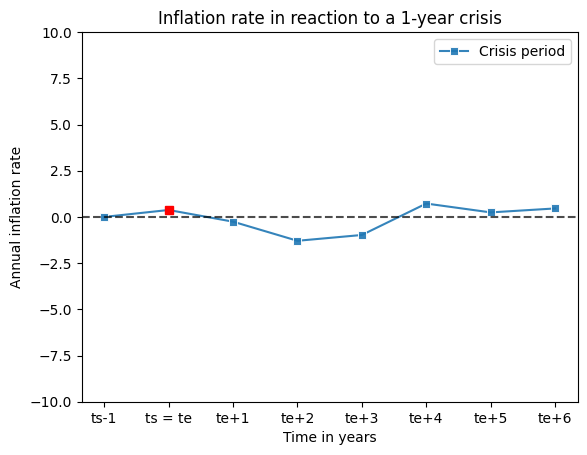

14


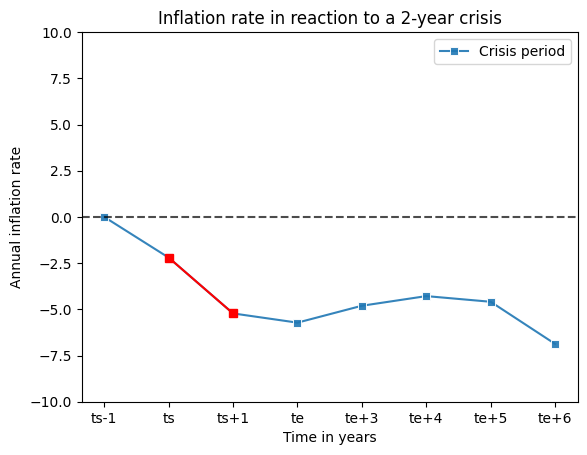

8


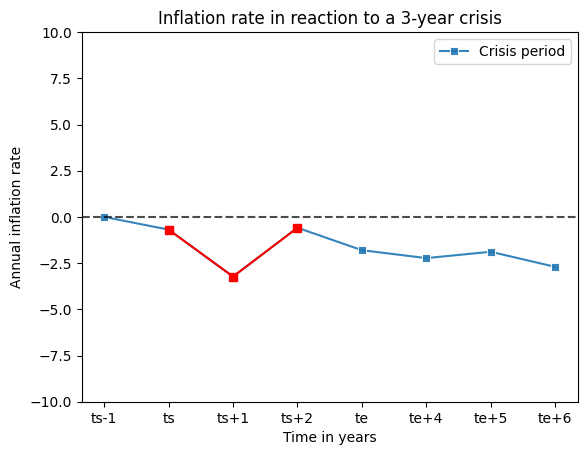

4


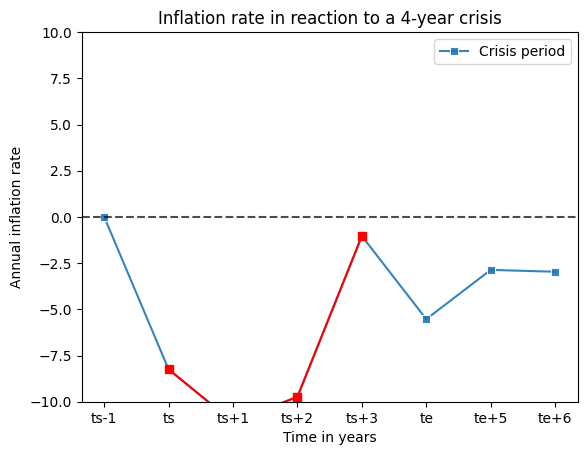

1


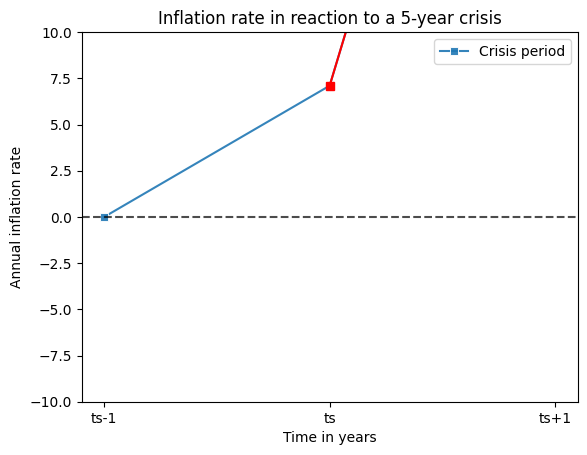

1


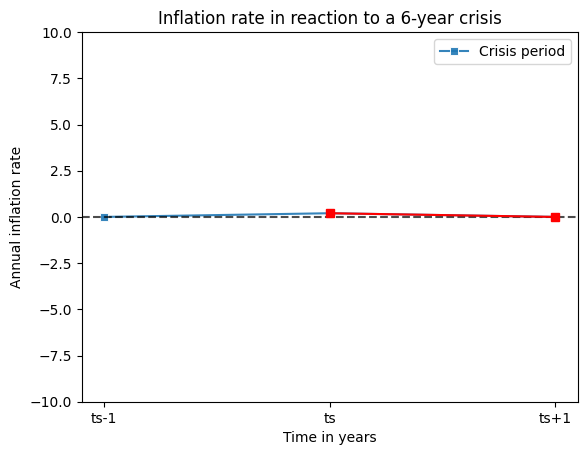

2


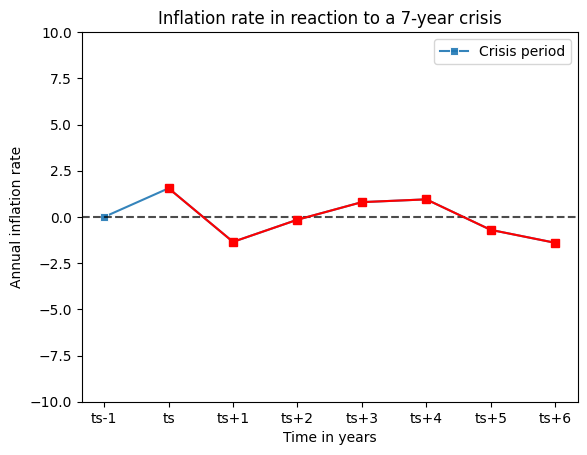

2


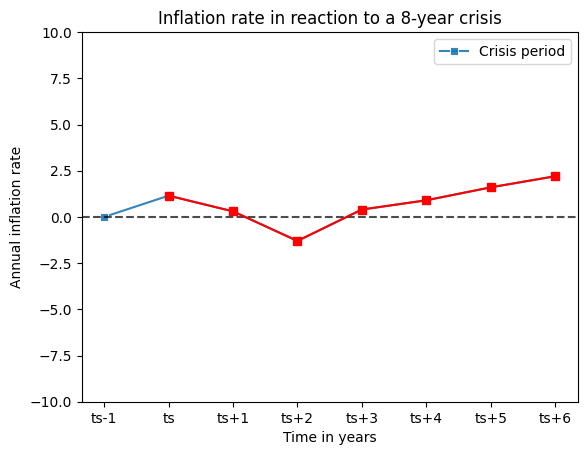

1


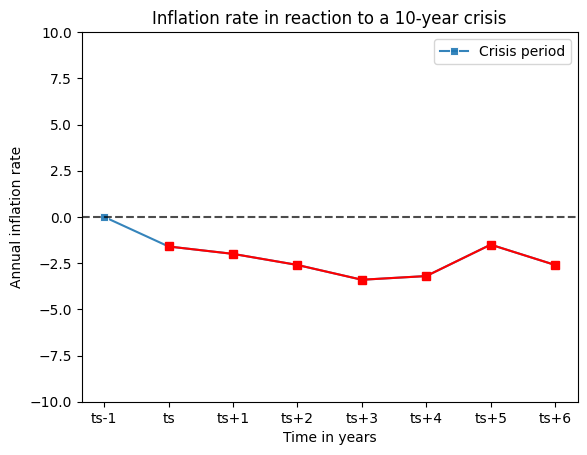

In [184]:
for i in len_freq.Length:
    series_by_crisis_length = []
    #Appending the series for single year crisis
    for j in range (0,len(norm_inflation_series)):
        if crisis_duration[j] == i:
            series_by_crisis_length.append(norm_inflation_series[j])
    print(len(series_by_crisis_length))

    average_pattern = compute_pattern(series_by_crisis_length)
    # confidence_interval = 1.96 * np.std(normalize_crisis_data(series_by_crisis_length, axis=0) / np.sqrt(series_by_crisis_length.shape[0])

    if i == 1:
        years = [f"ts{k}" if k < 0
                 else f"te+{k}" if k > 0
                 else "ts = te"
                 for k in range(-1, len(average_pattern) - 1)]
    else:
        years = [f"ts{k}" if k < 0
                 else f"ts" if k == 0
                 else f"ts+{k}" if 0 < k < i
                 else "te" if k == i
                 else f"te+{k}"
                 for k in range(-1, len(average_pattern) - 1)]

    # plt.fill_between(
    #     range(len(average_pattern)),
    #     average_pattern - confidence_interval,
    #     average_pattern + confidence_interval,
    #     color='blue',
    #     alpha=0.1, label='95% CI'
    # )

    sns.lineplot(x = years, y = average_pattern, marker = 's', label = 'Crisis period', alpha = 0.9)
    plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.7)

    plt.plot(years[1:1+i], average_pattern[1:1+i], marker='s', color='red')  # Change marker color to red for example

    plt.title(f'Inflation rate in reaction to a {i}-year crisis')


    plt.xlabel('Time in years')
    plt.ylabel('Annual inflation rate')
    plt.ylim(-10, 10)

    plt.show()

# 3. Extracting output gap series

In [188]:
global_data_inner = concat_dataset(GDP_pc, data, countries_selected, 'inner')
global_data_inner

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,sovereign_external_debt_1,sovereign_external_debt_2,Defaults_External_Notes,GDP_Weighted_default,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap
0,9.0,CAN,Canada,1820,0.0,NaN,0.0,0,0.2627,NaN,...,0,0.0,NaN,0,NaN,NaN,0,0,0.0,-23.14
1,9.0,CAN,Canada,1830,0.0,NaN,0.0,0,0.2465,NaN,...,0,0.0,NaN,0,NaN,NaN,0,0,0.0,-18.82
2,9.0,CAN,Canada,1840,0.0,NaN,0.0,0,0.2561,NaN,...,0,0.0,NaN,0,NaN,NaN,0,0,0.0,-9.75
3,9.0,CAN,Canada,1850,0.0,NaN,0.0,0,0.2566,NaN,...,0,0.0,NaN,0,NaN,NaN,0,0,0.0,-0.92
4,9.0,CAN,Canada,1860,0.0,NaN,0.0,1,0.9902,NaN,...,0,0.0,NaN,0,NaN,NaN,0,0,0.0,3.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,66.0,USA,United States,2012,0.0,NaN,0.0,0,1.6251,NaN,...,0,0.0,NaN,0,0,2.1,1,0,0.0,-2.14
1304,66.0,USA,United States,2013,0.0,NaN,0.0,0,1.6556,NaN,...,0,0.0,NaN,0,0,1.5,1,0,0.0,-2.22
1305,66.0,USA,United States,2014,0.0,NaN,0.0,0,1.5573,NaN,...,0,0.0,NaN,0,0,1.6,1,0,0.0,-1.66
1306,66.0,USA,United States,2015,NaN,NaN,0.0,0,1.4738,NaN,...,0,0.0,NaN,0,0,0.1,1,0,NaN,-0.88


In [190]:
# Generate a boolean mask where True indicates non-NaN values
not_nan_mask = ~np.isnan(global_data_inner['output_gap'])

# Creating a dummy for the years with a banking crisis and no inflation crisis
global_data_inner['banking_crisis_only'] = ((global_data_inner['banking_crisis'] == 1) &
                                            (global_data_inner['inflation_crisis'] != 1) &
                                            (global_data_inner['currency_crisis'] != 1) &
                                            not_nan_mask )
global_data_inner['banking_crisis_only'] = global_data_inner['banking_crisis_only'].astype(int)

#Create a dummy variable for excluded years
global_data_inner['excluded_years'] = ((global_data_inner['inflation_crisis'] == 1) &
                                (global_data_inner['currency_crisis'] != 1))

# Creating a dummy for the first years of crisis with a banking crisis and no inflation crisis
global_data_inner['banking_crisis_only_first_year'] = 0

# Initialize variable to keep track of the last row where Dummy took value 1
last_crisis_year = None
crisis_period = False
banking_crisis_only_previous = None

for index, row in global_data_inner.iterrows():
    if row['banking_crisis'] == 1:
        crisis_already_begun = False
        if row['banking_crisis_only'] == 1 and banking_crisis_only_previous != 1:
            if not crisis_already_begun:
                if last_crisis_year is None:
                    global_data_inner.at[index, 'banking_crisis_only_first_year'] = 1
                # If the current row's Dummy column is 1, check the year difference
                if ((last_crisis_year is not None and row['Year'] - last_crisis_year >= 2) or (last_crisis_year is not None and row['Year'] - last_crisis_year <0)):
                    global_data_inner.at[index, 'banking_crisis_only_first_year'] = 1
                    crisis_already_begun = True
        last_crisis_year = row['Year']
        banking_crisis_only_previous = row['excluded_years']

    else:
        crisis_already_begun = False

#Create a dummy for banking crisis years but not being the first year of a crisis
global_data_inner['banking_crisis_only_not_first'] = global_data_inner['banking_crisis_only'] - global_data_inner['banking_crisis_only_first_year']

#Create a dummy for recovery period
global_data_inner['recovery_only'] = ((global_data_inner['banking_crisis'] != 1) &
                                (global_data_inner['inflation_crisis'] != 1) &
                                (global_data_inner['systemic_crisis'] != 1) &
                                (global_data_inner['currency_crisis'] != 1) &
                                not_nan_mask)
global_data_inner['recovery_only'] = global_data_inner['recovery_only'].astype(int)

banking_crisis_only_first_year = global_data_inner[global_data_inner['banking_crisis_only_first_year'] == 1]['Year'].tolist()  #Appending those years to a list

print(f'In this approch, we record {len(banking_crisis_only_first_year)} different crisis event.')

In this approch, we record 61 different crisis event.


In [192]:
crisis_duration = []
current_length = 0

for index, row in global_data_inner.iterrows():
    if current_length > 0:
        if row['banking_crisis'] == 1:
            current_length += 1
        else:
            crisis_duration.append(current_length)
            current_length = 0
    else:
        if row['banking_crisis_only_first_year'] == 1:
           current_length = +1

#Check if the last sequence extends to the end of the dataset
if current_length > 0:
    crisis_duration.append(current_length)

print(crisis_duration)
print(len(crisis_duration))
print(banking_crisis_only_first_year)
print(len(banking_crisis_only_first_year))

[1, 2, 1, 1, 3, 2, 2, 1, 2, 2, 1, 1, 3, 2, 7, 1, 1, 1, 4, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 1, 6, 7, 1, 1, 1, 10, 1, 4, 2, 3, 2, 2, 1, 2, 1, 1, 3, 1, 1, 1, 8, 3, 1, 2, 1, 1, 1, 1, 1, 8, 4]
61
[1873, 1906, 1912, 1923, 1983, 1827, 1838, 1848, 1867, 1881, 1889, 1907, 1930, 1994, 2008, 1857, 1880, 1901, 1929, 1977, 2008, 1866, 1889, 1891, 1893, 1907, 1914, 1921, 1930, 1935, 1990, 2008, 1901, 1907, 1927, 1992, 1811, 1814, 1825, 1837, 1847, 1857, 1866, 1878, 1890, 1908, 1974, 1984, 1991, 1995, 2007, 1817, 1825, 1837, 1841, 1857, 1861, 1884, 1907, 1984, 2007]
61


In [193]:
length_counts = {}
for length in crisis_duration:
    if length in length_counts:
        length_counts[length] += 1
    else:
        length_counts[length] = 1

# Convert dictionary to pandas DataFrame
len_freq = pd.DataFrame(list(length_counts.items()), columns=['Length','Count'])
len_freq = len_freq.sort_values(by='Length')


# # Add a number of data points column
len_freq['Number of points'] = len_freq['Count'].sum() - len_freq['Count'].cumsum() + len_freq['Count']

# Sort DataFrame by length
len_freq.reset_index(drop=True, inplace=True)
len_freq

,Length,Count,Number of points
0,1,31,61
1,2,13,30
2,3,8,17
3,4,3,9
4,6,1,6
5,7,2,5
6,8,2,3
7,10,1,1


In [198]:
def extract_output_gap_series(data):
    ''' We want here to return the series of the inflaion rate for each first year of crisis until an inflation crisis happen or another banking crisis occurs.'''
    series = []
    current_serie = []

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if row['banking_crisis_only_first_year'] == 1:
            # Extract data during a crisis
            if index - 1 >= 0:
                current_serie.append(data.at[index - 1, 'output_gap'])
            current_serie.append(row['output_gap'])
            for i in range(1,7):
                if data.at[index + i, 'inflation_crisis'] == 1  or pd.isna(data.at[index + i,'annual_inflation']) or data.at[index + i, 'currency_crisis'] == 1 or (data.at[index + i, 'banking_crisis'] == 1 and data.at[index + i, 'banking_crisis_only_not_first'] != 1):
                    break
                current_serie.append(data.at[index + i,'output_gap'])
            series.append(current_serie)
            current_serie = []
    return series

In [199]:
output_gap_series = extract_output_gap_series(global_data_inner)
len(output_gap_series)

61

In [922]:
# def extract_output_gap_series(data, target_year):
#     target_index = data[data['Year'] == target_year].index[0]
#     series = data.loc[target_index-1:target_index+6, 'output_gap']
#     return np.array(series)

In [923]:
# output_gap_series = []
# for year in banking_crisis_first_year:
#     output_series_for_year = extract_output_gap_series(global_data_inner, year)
#     output_gap_series.append(output_series_for_year)
# output_gap_series = np.array(output_gap_series)

## 3.1 Output gap response for each length of crisis

31


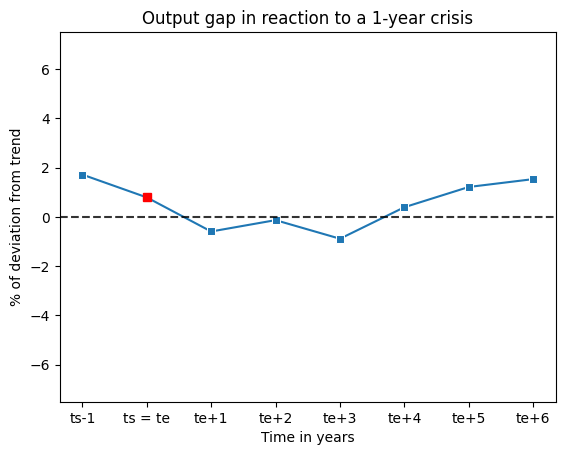

13


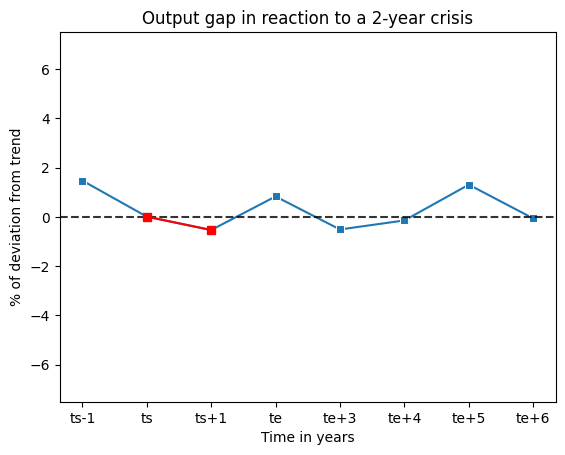

8


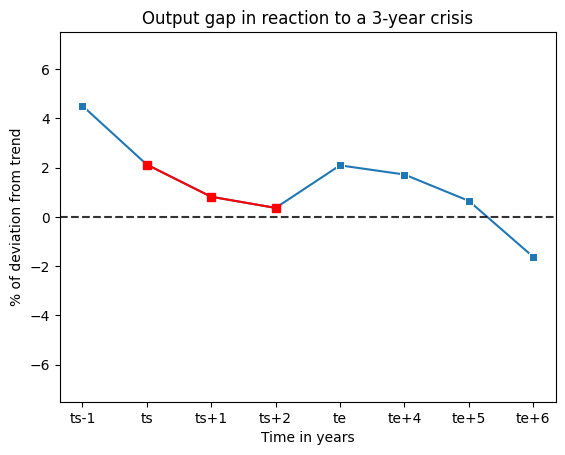

3


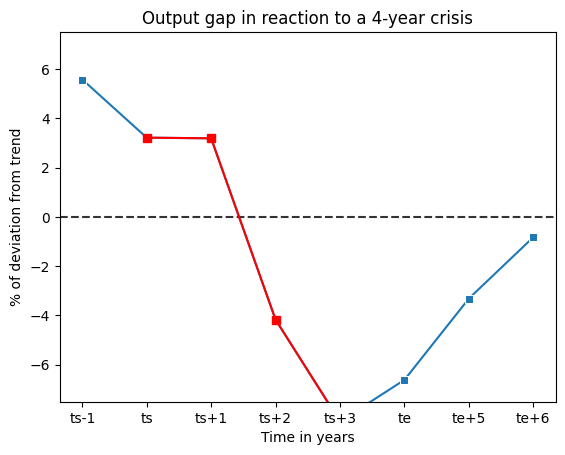

1


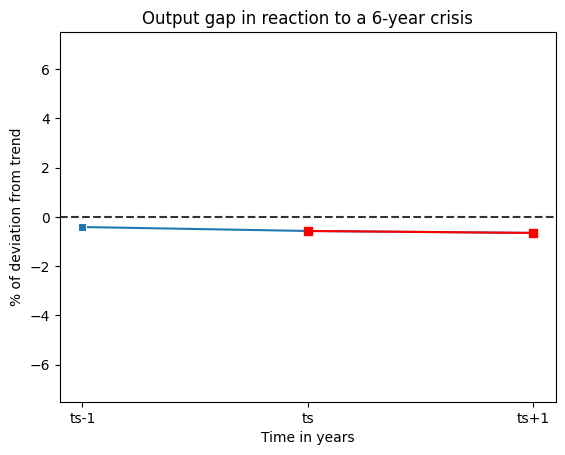

2


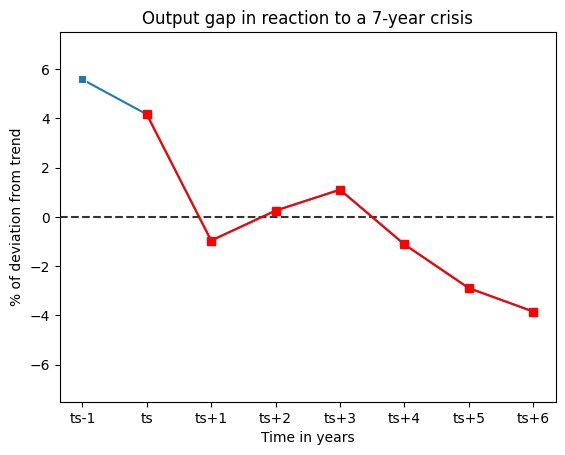

2


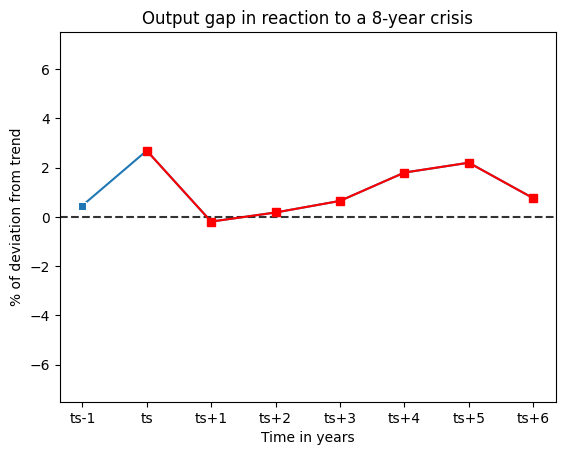

1


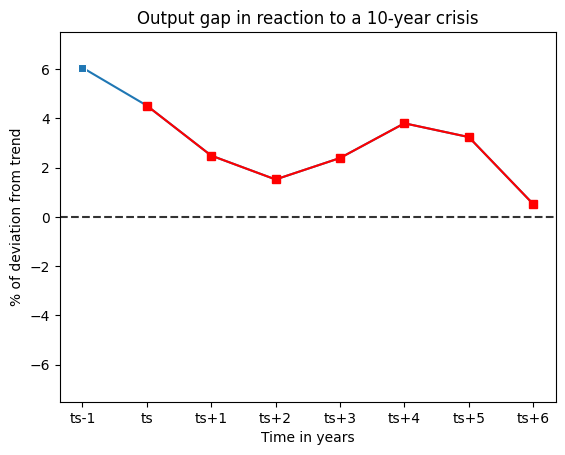

In [200]:
for i in len_freq.Length:
    series_by_crisis_length = []
    #Appending the series for single year crisis
    for j in range (0,len(output_gap_series)):
        if crisis_duration[j] == i:
            series_by_crisis_length.append(output_gap_series[j])
    print(len(series_by_crisis_length))

    average_pattern = compute_pattern(series_by_crisis_length)
    # confidence_interval = 1.96 * np.std(series_by_crisis_length, axis=0) / np.sqrt(series_by_crisis_length.shape[0])

    if i == 1:
        years = [f"ts{k}" if k < 0
                 else f"te+{k}" if k > 0
                 else "ts = te"
                 for k in range(-1, len(average_pattern) - 1)]
    else:
        years = [f"ts{k}" if k < 0
                 else f"ts" if k == 0
                 else f"ts+{k}" if 0 < k < i
                 else "te" if k == i
                 else f"te+{k}"
                 for k in range(-1, len(average_pattern) - 1)]

    # plt.fill_between(
    #     range(len(average_pattern)),
    #     average_pattern - confidence_interval,
    #     average_pattern + confidence_interval,
    #     color='blue',
    #     alpha=0.1, label='95% CI'
    # )

    sns.lineplot(x = years, y = average_pattern, marker = 's')
    plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.8)

    plt.plot(years[1:1+i], average_pattern[1:1+i], marker='s', color='red')  # Change marker color to red for example

    plt.title(f'Output gap in reaction to a {i}-year crisis')

    plt.xlabel('Time in years')
    plt.ylabel('% of deviation from trend')
    plt.ylim(-7.5,7.5)

    plt.show()


# 4. Crisis & recovery Dynamics in a multiple country database

In [925]:
def crisis_data(data, during_crisis=True):

    ''' This function is extracting the series of the annual inflation rate for each banking crisis or recovery period.
    Input:
    - dataframe
    - during_crisis = True or False (True for the series each banking crisis, False for the series of each recovery period)
    Output:
    - a list of series

    If during_crisis = True:
        The function extracts the series of the inflation rate for time [Ts-1,..., Te]
        s being the year of the beginning ot the crisis, e being the last year of the crisis.
    If during_crisis = False:
        The function extracts the series of the inflation rate for time [Te+1,..., Ts-1]
        e being the last year of the previous crisis, s being the year of the beginning ot the next crisis.
    '''

    series = []
    crisis_started = False
    no_crisis_period = False
    current_serie = []

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if not pd.isna(row['annual_inflation']):
            if during_crisis:
                # Extract data during a crisis
                if row['banking_crisis_only'] == 1:
                    if not crisis_started:
                        crisis_started = True
                        # Append the inflation rate for the year before the crisis
                        if index - 1 >= 0:
                            current_serie.append(data.at[index - 1, 'annual_inflation'])
                        current_serie.append(row['annual_inflation'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['annual_inflation'])
                elif crisis_started:
                    # End the series when a 0 is recorded in the banking_crisis column
                    crisis_started = False
                    series.append(current_serie)
                    current_serie = []
            else:
                # Extract data during a non-crisis period
                if row['recovery_only'] == 1:
                    if not no_crisis_period:
                        no_crisis_period = True
                        # Append the inflation rate for the current year
                        current_serie.append(row['annual_inflation'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['annual_inflation'])
                elif no_crisis_period:
                    # End the series when a 0 is recorded in the banking_crisis column
                    no_crisis_period = False
                    # current_serie = np.array(current_serie)
                    series.append(current_serie)
                    # current_serie = current_serie.tolist()
                    current_serie = []
    # if not during_crisis:
    #     series = series[1:]
    return series

In [926]:
def extract_inflation_series(data):
    ''' We want here to return the series of the inflaion rate for each first year of crisis until an inflation crisis happen or another banking crisis occurs.'''
    series = []
    current_serie = []

    for index, row in data.iterrows():
        if not pd.isna(row['annual_inflation']):
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
            if row['banking_crisis_only_first_year'] == 1:
                # Extract data during a crisis
                if index - 1 >= 0:
                    current_serie.append(data.at[index - 1, 'annual_inflation'])
                current_serie.append(row['annual_inflation'])
                for i in range(1,7):
                    if data.at[index + i, 'inflation_crisis'] == 1  or pd.isna(data.at[index + i,'annual_inflation']) or data.at[index + i, 'currency_crisis'] == 1 or (data.at[index + i, 'banking_crisis'] == 1 and data.at[index + i, 'banking_crisis_only_not_first'] != 1):
                        break
                    current_serie.append(data.at[index + i,'annual_inflation'])
                series.append(current_serie)
                current_serie = []
    return series

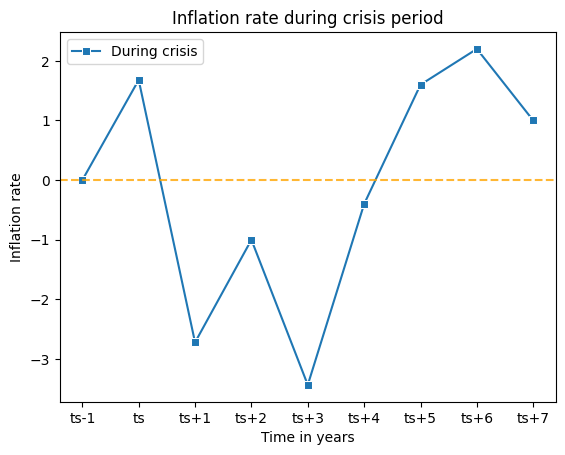

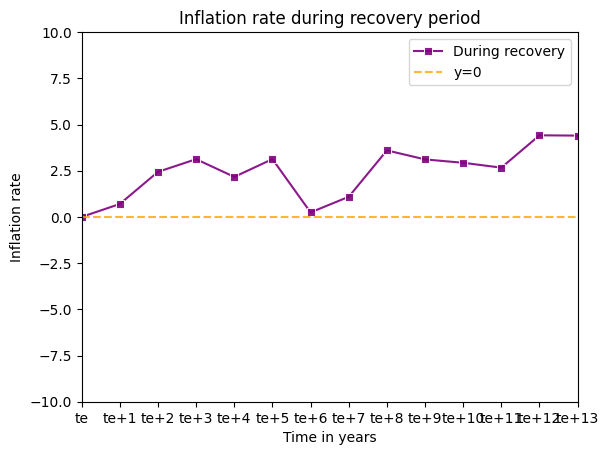

In [927]:
#Compute the average response pattern by time elapsed with normalizing the inflation series
pattern_during_crisis = compute_pattern(normalize_crisis_data(crisis_data(global_data, during_crisis = True)))
pattern_during_recovery = compute_pattern(normalize_crisis_data(crisis_data(global_data, during_crisis = False)))

#Compute the average response pattern by time elapsed without normalizing the inflation series
# pattern_during_crisis = compute_pattern(crisis_data(global_data, during_crisis = True))
# pattern_during_recovery = compute_pattern(crisis_data(global_data, during_crisis = False))

#Plot the inflation rate during banking crsis period
years = [f"ts{i}" if i < 0 else f"ts+{i}" if i > 0 else "ts" for i in range(-1, len(pattern_during_crisis) - 1)]
sns.lineplot(x = years, y = pattern_during_crisis, marker = 's', label = 'During crisis')

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Inflation rate during crisis period')

plt.xlabel('Time in years')
plt.ylabel('Inflation rate')

plt.show()

#Plot the inflation rate during recovery period
years = [f"te+{i}" if i > 0 else "te" for i in range(0, len(pattern_during_recovery))]
sns.lineplot(x = years, y = pattern_during_recovery, marker = 's', color = 'Purple', alpha = 0.9, label = 'During recovery')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Inflation rate during recovery period')

plt.xlabel('Time in years')
plt.ylabel('Inflation rate')
plt.ylim(-10, 10)
plt.xlim('te', 'te+13')
plt.legend()

plt.show()

In [928]:
def output_crisis_data(data, during_crisis=True):
    ''' This function is extracting the series of the annual inflation rate for each banking crisis or recovery period.
    Input:
    - dataframe
    - during_crisis = True or False (True for the series each banking crisis, False for the series of each recovery period)
    Output:
    - a list of series

    If during_crisis = True:
        The function extracts the series of the inflation rate for time [Ts-1,..., Te]
        s being the year of the beginning ot the crisis, e being the last year of the crisis.
    If during_crisis = False:
        The function extracts the series of the inflation rate for time [Te+1,..., Ts-1]
        e being the last year of the previous crisis, s being the year of the beginning ot the next crisis.
    '''
    series = []
    crisis_started = False
    no_crisis_period = False
    current_serie = []

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if not pd.isna(row['output_gap']):
            if during_crisis:
                # Extract data during a crisis
                if row['banking_crisis_only'] == 1:
                    if not crisis_started:
                        crisis_started = True
                        # Append the inflation rate for the year before the crisis
                        if index - 1 >= 0:
                            current_serie.append(data.at[index - 1, 'output_gap'])
                        current_serie.append(row['output_gap'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['output_gap'])
                elif crisis_started:
                    # End the series when a 0 is recorded in the banking_crisis column
                    crisis_started = False
                    series.append(current_serie)
                    current_serie = []
            else:
                # Extract data during a non-crisis period
                if row['recovery_only'] == 1:

                    if not no_crisis_period:
                        no_crisis_period = True
                        # Append the inflation rate for the current year
                        current_serie.append(row['output_gap'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['output_gap'])
                elif no_crisis_period:
                    # End the series when a 0 is recorded in the banking_crisis column
                    no_crisis_period = False
                    # current_serie = np.array(current_serie)
                    series.append(current_serie)
                    # current_serie = current_serie.tolist()
                    current_serie = []
    # if not during_crisis:
    #     series = series[1:]
    return series

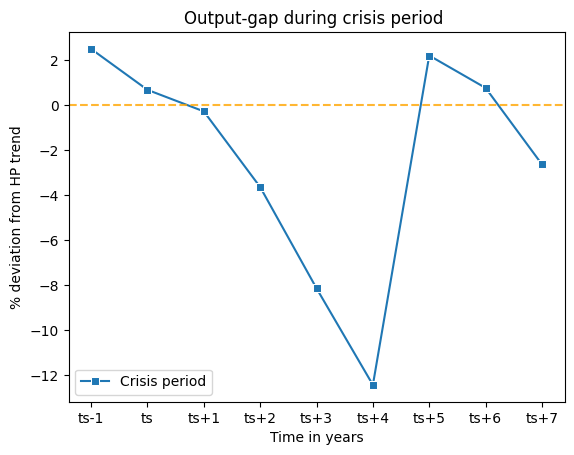

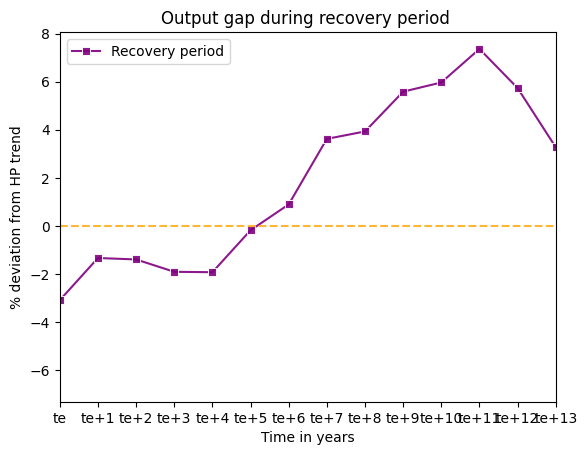

In [929]:
pattern_during_crisis = compute_pattern(output_crisis_data(global_data_inner, during_crisis = True))
pattern_during_recovery = compute_pattern(output_crisis_data(global_data_inner, during_crisis = False))

years = [f"ts{i}" if i < 0 else f"ts+{i}" if i > 0 else "ts" for i in range(-1, len(pattern_during_crisis) - 1)]
sns.lineplot(x = years, y = pattern_during_crisis, marker = 's', label = 'Crisis period')

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Output-gap during crisis period ')

plt.xlabel('Time in years')
plt.ylabel('% deviation from HP trend')

plt.show()

years = [f"te+{i}" if i > 0 else "te" for i in range(0, len(pattern_during_recovery))]
sns.lineplot(x = years, y = pattern_during_recovery, marker = 's', color = 'Purple', alpha = 0.9, label = 'Recovery period')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Output gap during recovery period ')

plt.xlabel('Time in years')
plt.ylabel('% deviation from HP trend')
plt.xlim('te', 'te+13')

plt.show()